In [1]:
from PIL import Image
import numpy as np
import torch
from torch import Tensor
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
class Attack(object):
    def __init__(self, model):
        import pickle
        self.model = model.cuda()
        self.model.training = False
        self.model.transform_input = False
        self.model.eval()
        # get the number to label dictionary
        with open("ImageNet_label_dict.pb","rb") as f:
            self.dict = pickle.load(f)
            
        self.normalize = transforms.Normalize(
           mean=[0.485, 0.456, 0.406],
           std=[0.229, 0.224, 0.225]
        )

        self.transform = transforms.Compose([
           transforms.Resize(255),
           transforms.CenterCrop(224),
           transforms.ToTensor()
#            ,self.normalize
        ])
        self.inv_normalize = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
            std=[1/0.229, 1/0.224, 1/0.255]
        )
    def inv_norm(self, orr_img0):
        import numpy as np
        if type(orr_img0)==np.ndarray:
            return inv_normalize(Tensor(orr_img0)).numpy()
        elif type(orr_img0)==torch.Tensor:
            return inv_normalize(orr_img0.clone()).numpy()
        else:
            return None   
        
    def perturb(self, img, steps=10, attack_target=0, eps = 0.001, alpha = 0.01):
        """
        img is the file path for image
        set attack_target = -1 for non targeted attack
        """
        img_pil = Image.open(img)
        img_variable = self.transform(img_pil)
        img_variable.unsqueeze_(0) # change the shape from 3x244x244 to 1x3x244x244
        img_variable_cuda = img_variable.clone().cuda()
        x = img_variable_cuda.clone()
        img_variable_cuda.requires_grad = True
#         criterion = nn.MSELoss()
        criterion = nn.CrossEntropyLoss().cuda()
        optimizer = optim.SGD([img_variable_cuda], lr=0.1, momentum=0.9)
        
        fake_label = torch.zeros([1,1000]).cuda()
        fake_label[0,attack_target] = 1.0
        # show the original image prediction
        fc_out = self.model(img_variable.cuda())
        print("original prediction:", self.dict[fc_out.cpu().data.numpy().argmax()])
        real_label = torch.zeros([1,1000]).cuda()
        real_label[0, fc_out.cpu().data.numpy().argmax()] = 1.0
        
        if type(attack_target)!=int or attack_target<-1 or attack_target>999:
            raise ValueError('attack_target mush be integer and within (-1,999)')
        elif attack_target==-1:
            # non targeted attack, easier
            y = real_label.clone()
        else:
            # targeted attack, harder
            alpha = -1*alpha
            y = fake_label.clone()
            
        if type(criterion)==torch.nn.modules.loss.CrossEntropyLoss:
            y = y.argmax().cuda().unsqueeze_(0)
        ####### attacking loop
        
        for i in range(steps):
            fc_out = self.model(img_variable_cuda)
            loss = criterion(fc_out, y)
            loss.backward()
            img_variable_cuda.data = alpha*torch.sign(img_variable_cuda.grad.data)+img_variable_cuda.data
            img_variable_cuda.data = torch.where(img_variable_cuda.data>x+eps, x+eps, img_variable_cuda.data)
            img_variable_cuda.data = torch.where(img_variable_cuda.data<x-eps, x-eps, img_variable_cuda.data)
            img_variable_cuda.data = torch.clamp(img_variable_cuda.data, 0, 1)
            img_variable_cuda.grad.data.fill_(0)
        # show the attack results
        fc_out = self.model(img_variable_cuda)
        print("attack prediction:", self.dict[fc_out.cpu().data.numpy().argmax()])
        
        # plot the orginal image and attacked image
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        orr_img = img_variable[0]
#         orr_img = self.inv_normalize(orr_img.clone())
        orr_img = orr_img.transpose(0,2).transpose(0,1).cpu().detach().numpy()
        plt.imshow(orr_img)
        out_img = img_variable_cuda[0]
#         out_img = self.inv_normalize(out_img.cpu().clone())
        out_img = out_img.transpose(0,2).transpose(0,1).cpu().detach().numpy()
        plt.subplot(122)
        plt.imshow(out_img)

In [3]:
resnet = models.resnet152(pretrained=True)

original prediction: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
attack prediction: toilet tissue, toilet paper, bathroom tissue


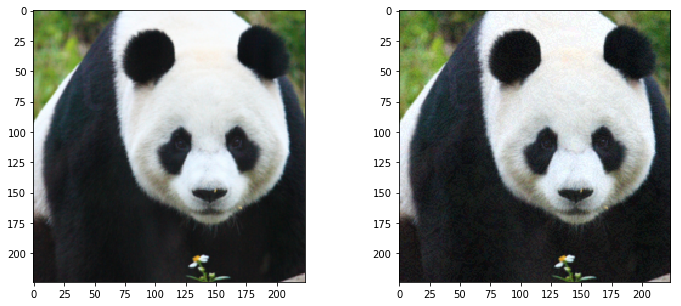

In [6]:
attack_resnet = Attack(resnet)
attack_resnet.perturb("panda.jpg", steps=140, attack_target=-1, eps = 0.015, alpha = 1)

original prediction: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
attack prediction: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca


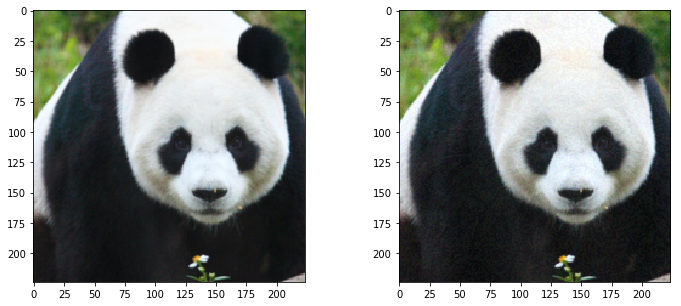

In [7]:
attack_resnet.perturb("panda.jpg", steps=140, attack_target=32, eps = 0.015, alpha = 1)